## Importing Required Libraries

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

from keras import backend as K
from keras.constraints import unit_norm, max_norm
import tensorflow as tf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from numpy.linalg import det, inv

##Dataset for one parameter estimation is generated using above equation where we consider random values of k and we get temperature values at 11 different points along the length of slab

# Data generation

In [ ]:
np.random.seed(42)
k_values = np.random.rand(1000) * 190 + 10
x = np.linspace(0.0,1.0,11)
print(x)
t_values = []
for k in k_values:
    temp = 1000.0*((1-x)/k+1.0/12.5)+298
    t_values.append(temp)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [ ]:
#convertint the temperature values array to CSV file
import csv

# field names
fields = ['x1', 'x2', 'x3', 'x4','x5','x6','x7','x8','x9','x10','x11']
with open('Temp_data1D.csv', 'w') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(fields)
    write.writerows(t_values)

## Reading data for 1 parameter estimation

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

data = pd.read_csv('/content/Temp_data1D.csv')
data = pd.DataFrame(data)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,390.320942,389.088848,387.856754,386.624660,385.392565,384.160471,382.928377,381.696283,380.464188,379.232094,378.0
1,383.245607,382.721046,382.196485,381.671925,381.147364,380.622803,380.098243,379.573682,379.049121,378.524561,378.0
2,384.707860,384.037074,383.366288,382.695502,382.024716,381.353930,380.683144,380.012358,379.341572,378.670786,378.0
3,386.081127,385.273015,384.464902,383.656789,382.848676,382.040564,381.232451,380.424338,379.616225,378.808113,378.0
4,403.224790,400.702311,398.179832,395.657353,393.134874,390.612395,388.089916,385.567437,383.044958,380.522479,378.0


In [ ]:
data['k'] = k_values

In [ ]:
import numpy as np

# Select the last column of the DataFrame
k = data.iloc[:, -1]

# Calculate 5% of each value in y as standard deviation
k_std = k * 0.05

k_variance = k_std ** 2

# Calculate the logarithm of the 10% variance to get log variance
data['k_log_var_prior'] = np.log(k_variance)

# Display the first few entries of the DataFrame with the new 'log_var' column
data[['k_log_var_prior']].head()

,k_log_var_prior
0,2.801445
1,4.509264
2,4.017486
3,3.644983
4,1.368392


In [ ]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,k,k_log_var_prior
0,390.320942,389.088848,387.856754,386.624660,385.392565,384.160471,382.928377,381.696283,380.464188,379.232094,378.0,81.162623,2.801445
1,383.245607,382.721046,382.196485,381.671925,381.147364,380.622803,380.098243,379.573682,379.049121,378.524561,378.0,190.635718,4.509264
2,384.707860,384.037074,383.366288,382.695502,382.024716,381.353930,380.683144,380.012358,379.341572,378.670786,378.0,149.078849,4.017486
3,386.081127,385.273015,384.464902,383.656789,382.848676,382.040564,381.232451,380.424338,379.616225,378.808113,378.0,123.745112,3.644983
4,403.224790,400.702311,398.179832,395.657353,393.134874,390.612395,388.089916,385.567437,383.044958,380.522479,378.0,39.643542,1.368392


## Splitting data into independent and dependent variables

## Independent features are the values of temperature distribution along the length

In [ ]:
original_data_without_noise = data.iloc[:,:-3]
original_data_without_noise.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,390.320942,389.088848,387.856754,386.624660,385.392565,384.160471,382.928377,381.696283,380.464188,379.232094
1,383.245607,382.721046,382.196485,381.671925,381.147364,380.622803,380.098243,379.573682,379.049121,378.524561
2,384.707860,384.037074,383.366288,382.695502,382.024716,381.353930,380.683144,380.012358,379.341572,378.670786
3,386.081127,385.273015,384.464902,383.656789,382.848676,382.040564,381.232451,380.424338,379.616225,378.808113
4,403.224790,400.702311,398.179832,395.657353,393.134874,390.612395,388.089916,385.567437,383.044958,380.522479


## Dependent variable is the value of Thermal Conductivity

In [ ]:
y = data['k']
y.head()

0     81.162623
1    190.635718
2    149.078849
3    123.745112
4     39.643542
Name: k, dtype: float64

In [ ]:
y_log_var_prior = data['k_log_var_prior']
y_log_var_prior.head()

0    2.801445
1    4.509264
2    4.017486
3    3.644983
4    1.368392
Name: k_log_var_prior, dtype: float64

## Adding Noise in the temperature columns

## Adjust the value of noise standard deviation as needed for experimentation

In [ ]:
# Percentage of the standard deviation to be used for noise
percentage_std = 5 / 100

# Calculate standard deviations for each column
std_devs = original_data_without_noise.std()

# Generate noise for each element based on 5% of the column's standard deviation
noise = pd.DataFrame()
for column in original_data_without_noise.columns:
    column_noise = np.random.normal(0, std_devs[column] * percentage_std, size=original_data_without_noise.shape[0])
    noise[column] = column_noise

# Add the noise to the original data
original_data_with_noise = original_data_without_noise + noise

# Show the modified DataFrame
print(original_data_with_noise.head())

           x1          x2          x3          x4          x5          x6  \
0  390.461831  388.085359  388.411437  386.541233  385.525327  383.671866   
1  382.186889  382.661745  381.784356  381.490612  381.286062  380.351456   
2  385.009297  382.963368  382.603129  382.116882  381.220454  381.535223   
3  386.565226  385.815359  383.803960  383.006211  382.383199  382.872343   
4  403.668615  400.761136  397.870812  395.915073  394.445546  390.557656   

           x7          x8          x9         x10  
0  383.309554  381.604445  380.347693  379.195808  
1  380.101030  379.815155  379.200703  378.609512  
2  380.701495  380.038042  379.529246  378.582800  
3  381.148222  381.044387  379.431546  378.833741  
4  388.306980  385.613439  382.854055  380.399781  


Standard Deviation of each column

In [ ]:
std_devs

x1     15.856853
x2     14.271168
x3     12.685483
x4     11.099797
x5      9.514112
x6      7.928427
x7      6.342741
x8      4.757056
x9      3.171371
x10     1.585685
dtype: float64

Noise Dataframe

In [ ]:
noise

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.140889,-1.003490,0.554684,-0.083426,0.132762,-0.488605,0.381177,-0.091838,-0.116496,-0.036287
1,-1.058718,-0.059301,-0.412129,-0.181313,0.138698,-0.271347,0.002787,0.241473,0.151581,0.084951
2,0.301437,-1.073706,-0.763159,-0.578620,-0.804262,0.181293,0.018351,0.025684,0.187674,-0.087986
3,0.484098,0.542344,-0.660942,-0.650578,-0.465478,0.831780,-0.084229,0.620049,-0.184679,0.025628
4,0.443826,0.058826,-0.309020,0.257721,1.310672,-0.054739,0.217065,0.046002,-0.190903,-0.122698
...,...,...,...,...,...,...,...,...,...,...
995,-1.046570,-0.203275,0.299087,0.434352,-0.619771,0.325885,0.191067,-0.327594,0.251712,0.017169
996,-0.485037,-0.182799,-1.161448,-0.013449,0.215051,0.345740,0.329841,-0.081663,0.063427,-0.124653
997,-0.029364,-0.172323,-0.779170,0.667348,-0.169339,0.128455,-0.323121,0.271677,0.026300,-0.024377
998,-0.340369,-0.044072,-1.316492,-0.607864,0.013886,0.326692,-0.072235,0.275254,0.132720,0.030917


In [ ]:
# Concatenate the dataframes and series
result_without_noise = pd.concat([original_data_without_noise, y, y_log_var_prior], axis=1)

# Display the first few entries of the concatenated DataFrame
result_without_noise.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k,k_log_var_prior
0,390.320942,389.088848,387.856754,386.624660,385.392565,384.160471,382.928377,381.696283,380.464188,379.232094,81.162623,2.801445
1,383.245607,382.721046,382.196485,381.671925,381.147364,380.622803,380.098243,379.573682,379.049121,378.524561,190.635718,4.509264
2,384.707860,384.037074,383.366288,382.695502,382.024716,381.353930,380.683144,380.012358,379.341572,378.670786,149.078849,4.017486
3,386.081127,385.273015,384.464902,383.656789,382.848676,382.040564,381.232451,380.424338,379.616225,378.808113,123.745112,3.644983
4,403.224790,400.702311,398.179832,395.657353,393.134874,390.612395,388.089916,385.567437,383.044958,380.522479,39.643542,1.368392


In [ ]:
result = pd.concat([original_data_with_noise, y, y_log_var_prior], axis=1)
result.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k,k_log_var_prior
0,390.461831,388.085359,388.411437,386.541233,385.525327,383.671866,383.309554,381.604445,380.347693,379.195808,81.162623,2.801445
1,382.186889,382.661745,381.784356,381.490612,381.286062,380.351456,380.101030,379.815155,379.200703,378.609512,190.635718,4.509264
2,385.009297,382.963368,382.603129,382.116882,381.220454,381.535223,380.701495,380.038042,379.529246,378.582800,149.078849,4.017486
3,386.565226,385.815359,383.803960,383.006211,382.383199,382.872343,381.148222,381.044387,379.431546,378.833741,123.745112,3.644983
4,403.668615,400.761136,397.870812,395.915073,394.445546,390.557656,388.306980,385.613439,382.854055,380.399781,39.643542,1.368392


## Normalizing the combined Dataframe

Getting mean and standard deviation of each column

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_and_store_params(df):
    scaler = StandardScaler()
    standardized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Storing means and scales (standard deviations)
    params = {
        'mean': scaler.mean_,
        'scale': scaler.scale_
    }
    return standardized_df, params

# Standardizing and storing parameters
standardized_df, params = standardize_and_store_params(result)
print("Standardized DataFrame:")
print(standardized_df)
print("\nStored Parameters:")
print(params)

Standardized DataFrame:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.242776 -0.318661 -0.202682 -0.251064 -0.231564 -0.307002 -0.186806   
1   -0.763309 -0.699086 -0.724214 -0.704988 -0.676511 -0.725701 -0.692707   
2   -0.585766 -0.677930 -0.659779 -0.648702 -0.683397 -0.576430 -0.598029   
3   -0.487891 -0.477884 -0.565277 -0.568774 -0.561357 -0.407821 -0.527592   
4    0.587994  0.570448  0.541743  0.591409  0.704688  0.561288  0.601159   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.203227  1.263567  1.299181  1.316356  1.211850  1.319899  1.307903   
996 -0.715859 -0.696345 -0.771811 -0.678537 -0.657122 -0.636498 -0.629746   
997  0.719040  0.715618  0.665690  0.789056  0.710340  0.745570  0.677219   
998 -0.717965 -0.697861 -0.795227 -0.743167 -0.689454 -0.650132 -0.704378   
999 -0.397253 -0.335753 -0.361805 -0.513114 -0.321855 -0.364931 -0.405284   

           x8        x9       x10         k  k_log_

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler = StandardScaler()

# Normalize the DataFrame and create a new DataFrame
result_without_noise = pd.DataFrame(scaler.fit_transform(result_without_noise), columns=result.columns)

print("\nStandardized DataFrame:")
print(result_without_noise)


Standardized DataFrame:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.247455 -0.247455 -0.247455 -0.247455 -0.247455 -0.247455 -0.247455   
1   -0.693879 -0.693879 -0.693879 -0.693879 -0.693879 -0.693879 -0.693879   
2   -0.601617 -0.601617 -0.601617 -0.601617 -0.601617 -0.601617 -0.601617   
3   -0.514970 -0.514970 -0.514970 -0.514970 -0.514970 -0.514970 -0.514970   
4    0.566723  0.566723  0.566723  0.566723  0.566723  0.566723  0.566723   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.277861  1.277861  1.277861  1.277861  1.277861  1.277861  1.277861   
996 -0.682481 -0.682481 -0.682481 -0.682481 -0.682481 -0.682481 -0.682481   
997  0.728023  0.728023  0.728023  0.728023  0.728023  0.728023  0.728023   
998 -0.693721 -0.693721 -0.693721 -0.693721 -0.693721 -0.693721 -0.693721   
999 -0.358873 -0.358873 -0.358873 -0.358873 -0.358873 -0.358873 -0.358873   

           x8        x9       x10         k  k_log

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler = StandardScaler()

# Normalize the DataFrame and create a new DataFrame
result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

print("\nStandardized DataFrame:")
print(result)


Standardized DataFrame:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.242776 -0.318661 -0.202682 -0.251064 -0.231564 -0.307002 -0.186806   
1   -0.763309 -0.699086 -0.724214 -0.704988 -0.676511 -0.725701 -0.692707   
2   -0.585766 -0.677930 -0.659779 -0.648702 -0.683397 -0.576430 -0.598029   
3   -0.487891 -0.477884 -0.565277 -0.568774 -0.561357 -0.407821 -0.527592   
4    0.587994  0.570448  0.541743  0.591409  0.704688  0.561288  0.601159   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.203227  1.263567  1.299181  1.316356  1.211850  1.319899  1.307903   
996 -0.715859 -0.696345 -0.771811 -0.678537 -0.657122 -0.636498 -0.629746   
997  0.719040  0.715618  0.665690  0.789056  0.710340  0.745570  0.677219   
998 -0.717965 -0.697861 -0.795227 -0.743167 -0.689454 -0.650132 -0.704378   
999 -0.397253 -0.335753 -0.361805 -0.513114 -0.321855 -0.364931 -0.405284   

           x8        x9       x10         k  k_log

In [ ]:
result.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k,k_log_var_prior
0,-0.242776,-0.318661,-0.202682,-0.251064,-0.231564,-0.307002,-0.186806,-0.269009,-0.283061,-0.269547,-0.396301,-0.044916
1,-0.763309,-0.699086,-0.724214,-0.704988,-0.676511,-0.725701,-0.692707,-0.645311,-0.644549,-0.639784,1.576957,1.138607
2,-0.585766,-0.677930,-0.659779,-0.648702,-0.683397,-0.576430,-0.598029,-0.598436,-0.541005,-0.656652,0.827893,0.797804
3,-0.487891,-0.477884,-0.565277,-0.568774,-0.561357,-0.407821,-0.527592,-0.386793,-0.571796,-0.498187,0.371251,0.539658
4,0.587994,0.570448,0.541743,0.591409,0.704688,0.561288,0.601159,0.574114,0.506849,0.490746,-1.144685,-1.038026


## Splitting the dataset into train and test

In [ ]:
x_train = result.iloc[:800,:-2]
x_test = result.iloc[800:,:-2]
x_train.shape, x_test.shape

y_train = result.iloc[:800,-2]
y_test = result.iloc[800:,-2]
y_train.shape, y_test.shape

((800,), (200,))

In [ ]:
x_train_wo_noise = result_without_noise.iloc[:800,:-2]
x_test_wo_noise = result_without_noise.iloc[800:,:-2]
x_train_wo_noise.shape, x_test_wo_noise.shape

y_train_wo_noise = result_without_noise.iloc[:800,-2]
y_test_wo_noise = result_without_noise.iloc[800:,-2]
y_train_wo_noise.shape, y_test_wo_noise.shape

((800,), (200,))

In [ ]:
y_train_log_var = result.iloc[:800,-1]
y_test_log_var = result.iloc[800:,-1]
y_train_log_var.shape, y_test_log_var.shape

((800,), (200,))

In [ ]:
training_feature = x_train
training_score_k = y_train

testing_feature_sk = x_test
testing_score = y_test

#**VAE**

## Reparameterization Trick Function

$\mu_z + \epsilon \sigma_z$

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## KL-Divergence Terms

KL-divergence loss = $\ln\frac{|\Gamma_{\text{pr}}|}{|\Gamma_{\text{post}}|} + \text{tr}(\Gamma_{\text{pr}}^{-1}\Gamma_{\text{post}}^{(m)}) + \|\mu_{\text{post}}^{(m)} - \mu_{\text{pr}}\|^2_{{\Gamma}_{pr}}$

$(\cdot)_p$ stands for prior and $(\cdot)_q$ stands for posterior

In [ ]:
def kl_divergence_multivariate_normal_keras(mu_p, log_var_p, mu_q, log_var_q):
    sigma_p = K.exp(log_var_p)            ## log variance to variance
    sigma_q = K.exp(log_var_q)

    term1 = K.sum(log_var_p - log_var_q)

    term2 = K.sum(sigma_q/sigma_p)

    term3 = K.sum(K.square(mu_q - mu_p) / sigma_p)

    return (term1 + term2 + term3)

In [ ]:
def js_divergence_multivariate_normal_keras(mu_post, log_var_post, inputs_k, js_param):
    var_post = K.exp(log_var_post)            ## log variance to variance

    term1 = K.sum(log_var_post)
    term2 = K.sum(K.square(mu_post - inputs_k) / var_post)

    return js_param*(term1 + term2)

## Also defining more variables for test and train

In [ ]:
original_dim = x_train.shape[1]
num_train = x_train.shape[0]
print(original_dim)

10


original_dim: Number of measuring locations

In [ ]:
input_shape_x = (original_dim, )
input_shape_k = (1, )
inputs_shape_log_var = (1,)

In [ ]:
intermediate_dim_1 = 8 # 1st layer
intermediate_dim_2 = 5 # 2nd Layer
intermediate_dim_3 = 3 # 3rd Layer
batch_size = 32
latent_dim = 1

#### **Surrogate of the forward model**

$$ F \approx \Psi_d$$

In [ ]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model

In [ ]:
inputs_x = Input(shape=input_shape_x, name='temp_input')
inputs_k = Input(shape=input_shape_k, name='ground_truth')
inputs_log_var = Input(shape=inputs_shape_log_var, name='prior_log_var')
# Physics informed decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_3, activation='tanh')(latent_inputs)
inter_y2 = Dense(intermediate_dim_2, activation='tanh')(inter_y1)
inter_y3 = Dense(intermediate_dim_1, activation='tanh')(inter_y2)
outputs = Dense(original_dim, activation='linear')(inter_y3)  # Typically linear for output in regression tasks

## Training the Decoder first so that it learns the data/ physics of the problem.
## Here no error is added in the independent features

In [ ]:
# instantiate decoder model
physics_informed_decoder = Model(latent_inputs, outputs, name='physics_informed_decoder')
physics_informed_decoder.summary()

Model: "physics_informed_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 3)                 6         
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
 dense_2 (Dense)             (None, 8)                 48        
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
Total params: 164 (656.00 Byte)
Trainable params: 164 (656.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/1000
25/25 [==============================] - 4s 44ms/step - loss: 1.0433 - val_loss: 1.1781
Epoch 2/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.9012

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 18ms/step - loss: 0.8990 - val_loss: 1.0477
Epoch 3/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.7836 - val_loss: 0.9351
Epoch 4/1000
25/25 [==============================] - 0s 19ms/step - loss: 0.6850 - val_loss: 0.8347
Epoch 5/1000
25/25 [==============================] - 0s 20ms/step - loss: 0.6012 - val_loss: 0.7495
Epoch 6/1000
25/25 [==============================] - 1s 26ms/step - loss: 0.5323 - val_loss: 0.6853
Epoch 7/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.4823 - val_loss: 0.6323
Epoch 8/1000
25/25 [==============================] - 1s 28ms/step - loss: 0.4438 - val_loss: 0.5909
Epoch 9/1000
25/25 [==============================] - 0s 20ms/step - loss: 0.4138 - val_loss: 0.5565
Epoch 10/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.3893 - val_loss: 0.5337
Epoch 11/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.3656 - val_loss: 0.5044
Ep

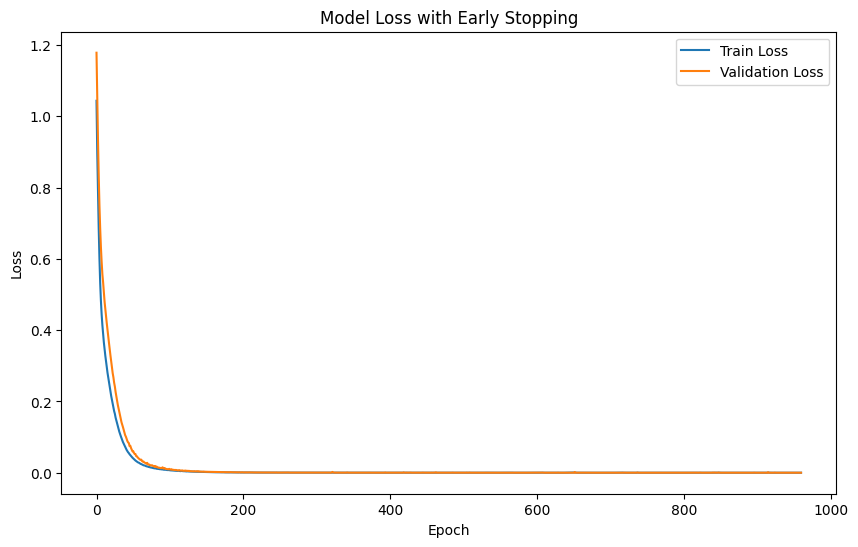

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming 'physics_informed_decoder' is your model
model = physics_informed_decoder

# Use Adam optimizer with the specified learning rate
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with MSE loss function for regression
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Setup EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

# Optional: Setup ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model_2.h5', monitor='val_loss', save_best_only=True, mode='min')

# Fit the model with the callbacks
# Ensure your training and validation datasets (y_train_wo_noise, x_train_wo_noise, etc.) are prepared correctly
history = model.fit(y_train_wo_noise, x_train_wo_noise,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(y_test_wo_noise, x_test_wo_noise),
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Early Stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### **VAE Model**

##### **Encoder**

In [ ]:
from keras.layers import Input, Dense, Lambda, Dropout, BatchNormalization
from keras.models import Model

# Input tensor
inputs_x = Input(shape=input_shape_x, name='temp_input')

# Dense layers with activations, followed by Batch Normalization and Dropout
inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# Mean and log variance for latent space
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate the encoder model
encoder = Model(inputs_x, [z_mean, z_log_var, z], name='encoder')

# Model summary to visualize the architecture
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temp_input (InputLayer)     [(None, 10)]                 0         []                            
                                                                                                  
 encoder_intermediate_1 (De  (None, 8)                    88        ['temp_input[0][0]']          
 nse)                                                                                             
                                                                                                  
 encoder_intermediate_2 (De  (None, 5)                    45        ['encoder_intermediate_1[0][0]
 nse)                                                               ']                            
                                                                                            

#### **Decoder**

Note: **The Decoder is the earlier pre-trained decoder with freezed weights**

In [ ]:
## Write code with decoder replaced with physics informed decoder with freezed weights

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# Load the saved model from the directory
model_path = '/content/best_model_2.h5'  # Update this path as necessary
physics_based_decoder = load_model(model_path, compile=False)

# Freeze the weights of the physics-based decoder
for layer in physics_based_decoder.layers:
    layer.trainable = False

outputs = physics_based_decoder(z)  # Connect encoder output 'z' to the physics-based decoder

decoder = Model(z, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 physics_informed_decoder (  (None, 10)                164       
 Functional)                                                     
                                                                 
Total params: 164 (656.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 164 (656.00 Byte)
_________________________________________________________________


## VAE Model Summary

In [ ]:
vae = Model([inputs_x,inputs_k,inputs_log_var], [outputs], name='vae_mlp')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temp_input (InputLayer)     [(None, 10)]                 0         []                            
                                                                                                  
 encoder_intermediate_1 (De  (None, 8)                    88        ['temp_input[0][0]']          
 nse)                                                                                             
                                                                                                  
 encoder_intermediate_2 (De  (None, 5)                    45        ['encoder_intermediate_1[0][0]
 nse)                                                               ']                            
                                                                                            

#### **Loss Function of VAE**

Reconstruction Loss : MSE Loss between the inputs to encoder and outputs from decoder

KL Divergence loss : Between inputs dependent (k) values and latent space

Label Loss : Also a KL Divergence loss between latent space and prior distribution

In [ ]:
from tensorflow.keras.optimizers import Adam
import numpy as np
from numpy.linalg import det, inv

# ##Customize Lost Function of the VAE Model

# J-S hyperparameter
alpha_js = 0.5
js_param = (1.0-alpha_js)/alpha_js

## Reconstruction Loss
reconstruction_loss = mse(inputs_x,outputs)
# reconstruction_loss = K.abs(reconstruction_loss)

## KL_Divergence Loss  post and prior
kl_loss = (1.0/x_train.shape[0])*kl_divergence_multivariate_normal_keras(inputs_k, inputs_log_var, z_mean, z_log_var)

## Label Loss  post and inputs
label_loss = (1.0/x_train.shape[0])*js_divergence_multivariate_normal_keras(z_mean,z_log_var,inputs_k,js_param)

## Combined Loss
vae_loss = K.sum(reconstruction_loss + kl_loss + label_loss)
vae.add_loss(vae_loss)

## Setting the Optimizer and the learning rate for the VAE Model

In [ ]:
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer)

## Setting maximum epochs as 1000 and patience in early stopping as 50

Epoch 1/1000
15/25 [=================>............] - ETA: 0s - loss: 90.8970 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 3s 41ms/step - loss: 92.5314 - val_loss: 70.8635
Epoch 2/1000
25/25 [==============================] - 0s 6ms/step - loss: 79.9745 - val_loss: 69.7513
Epoch 3/1000
25/25 [==============================] - 0s 6ms/step - loss: 57.6275 - val_loss: 59.0382
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 64.7317 - val_loss: 91.3694
Epoch 5/1000
25/25 [==============================] - 0s 6ms/step - loss: 60.6045 - val_loss: 55.9855
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 58.1218 - val_loss: 70.3015
Epoch 7/1000
25/25 [==============================] - 0s 5ms/step - loss: 51.9714 - val_loss: 42.5077
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 51.2914 - val_loss: 65.3071
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 47.2834 - val_loss: 57.6289
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 50.5714 - val_loss:

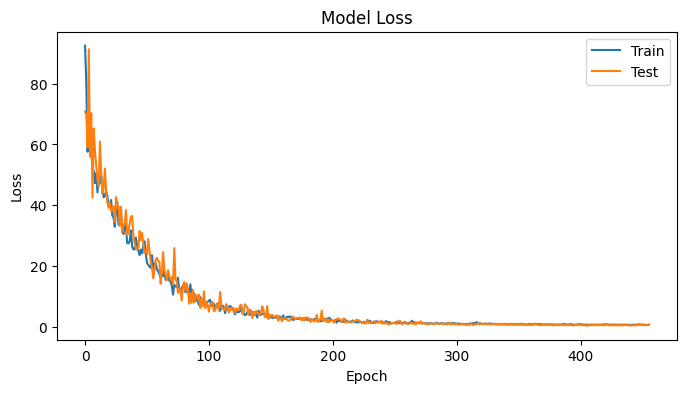

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vae.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model with validation data and callbacks
history = vae.fit([x_train, y_train, y_train_log_var], x_train,
                  epochs=1000,
                  batch_size=batch_size,
                  validation_data=([x_test, y_test, y_test_log_var], x_test),
                  callbacks=[early_stopping, model_checkpoint])

# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Plotting the results for Training Data

25/25 [==============================] - 0s 1ms/step
Mean squared error: 0.010
R2 Variance score: 0.990


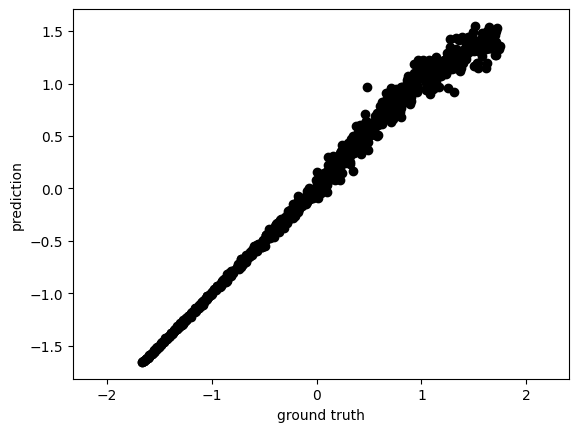

In [ ]:
[z_mean, z_log_var, z] = encoder.predict(x_train,batch_size=batch_size)
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_train, z_mean))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_train, z_mean))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_train, z_mean,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction')
ax.axis('equal');

## Plotting the results for test data

7/7 [==============================] - 0s 3ms/step
Mean squared error: 0.009
R2 Variance score: 0.991


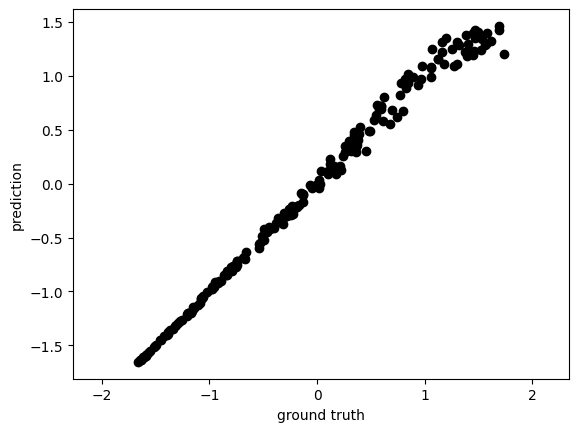

In [ ]:
[z_mean_t, z_log_var_t, z_t] = encoder.predict([x_test],batch_size=batch_size)
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, z_mean_t))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_test, z_mean_t))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_test, z_mean_t,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction')
ax.axis('equal');

In [ ]:
# Combine the training data and their encoded representations
train_combined = np.hstack((x_train, z_mean, z_log_var))

# Combine the test data and their encoded representations
test_combined = np.hstack((x_test, z_mean_t, z_log_var_t))

# Concatenate the training and test datasets row-wise
combined_data = np.vstack((train_combined, test_combined))

# Inverse transform to original scale
original_scale_data = scaler.inverse_transform(combined_data)

# Optionally convert to DataFrame for better readability and further processing
df = pd.DataFrame(original_scale_data, columns=[result.columns])

In [ ]:
# Rename the 'k' and 'k_log_var_prior' columns
df.rename(columns={'k': 'k_pred', 'k_log_var_prior': 'k_std_dev_pred'}, inplace=True)

# Convert log variance to standard deviation
# Since log variance is log(sigma^2), standard deviation sigma = sqrt(exp(log(sigma^2)))
df['k_std_dev_pred'] = np.sqrt(np.exp(df['k_std_dev_pred']))

df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k_pred,k_std_dev_pred
0,390.461831,388.085359,388.411437,386.541233,385.525327,383.671866,383.309554,381.604445,380.347693,379.195808,81.705716,0.073833
1,382.186889,382.661745,381.784356,381.490612,381.286062,380.351456,380.101030,379.815155,379.200703,378.609512,181.897429,2.004751
2,385.009297,382.963368,382.603129,382.116882,381.220454,381.535223,380.701495,380.038042,379.529246,378.582800,155.367677,0.890358
3,386.565226,385.815359,383.803960,383.006211,382.383199,382.872343,381.148222,381.044387,379.431546,378.833741,124.485293,0.321270
4,403.668615,400.761136,397.870812,395.915073,394.445546,390.557656,388.306980,385.613439,382.854055,380.399781,40.015460,0.020437
...,...,...,...,...,...,...,...,...,...,...,...,...
995,413.448989,410.642728,407.495535,403.981243,399.277565,396.573664,392.789290,388.621074,385.550824,381.666725,28.022492,0.015158
996,382.941206,382.700819,381.179546,381.784921,381.470797,381.058861,380.500338,379.546210,379.148675,378.417971,178.192250,1.910653
997,405.751855,402.830775,399.445806,398.114202,394.499393,392.019065,388.789366,386.606043,383.582544,380.753745,35.920968,0.018462
998,382.907732,382.679219,380.881989,381.065807,381.162747,380.950743,380.027006,379.849684,379.182341,378.555727,180.939849,2.130901


Mean squared error on original scale: 5.144
R2 Variance score on original scale: 0.991


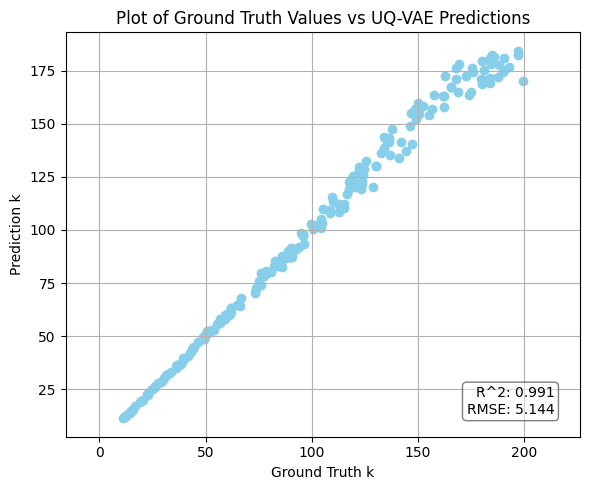

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming 'data' and 'combined_original' are previously defined pandas DataFrame and numpy array, respectively.

# Calculate metrics
rmse = np.sqrt(mean_squared_error(data.iloc[800:, -2], df.iloc[800:, -2]))
r2 = r2_score(data.iloc[800:, -2], df.iloc[800:, -2])

# Print metrics
print("Mean squared error on original scale: %.3f" % rmse)
print('R2 Variance score on original scale: %.3f' % r2)

# Plot Prediction vs. Ground-truth Y on original scale
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(data.iloc[800:, -2], df.iloc[800:, -2], color='skyblue')
ax.set_xlabel('Ground Truth k')
ax.set_ylabel('Prediction k')
ax.axis('equal')
ax.grid(True)
plt.title('Plot of Ground Truth Values vs UQ-VAE Predictions')

# Adding RMSE and R^2 text with bounding box
textstr = f'R^2: {r2:.3f}\nRMSE: {rmse:.3f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

## Comparison between UQVAE Results and MCMC

In [ ]:
import numpy as np

# Define an array of different k values
k_values = data.iloc[:,-2]

# Define a 2D array of different T values
T_values_2d = df.iloc[:,:-2]
T_values_2d = df.iloc[:,:-2].to_numpy()

# Initialize lists to store km and sq values for each set
km_list = []
sq_list = []

# Problem Parameters
q = 1000
L = 1.0
TL = 378
x = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
Nm = len(x)

# Priors
Ns = 10

for k, T_values in zip(k_values, T_values_2d):
        sigma_k = 0.05 * k
        kmin = k - sigma_k
        kmax = k + sigma_k
        ks = np.linspace(kmin, kmax, Ns)

        Tsim = np.zeros((Ns, Nm))
        P1 = np.zeros(Ns)
        P2 = np.zeros(Ns)
        P3a = np.zeros(Ns)

        for i in range(Ns):
            Tsim[i, :] = -q / ks[i] * x + q * L / ks[i] + TL
            e = Tsim[i, :] - T_values
            A = np.sum(e**2)
            B = (ks[i] - k)**2 / sigma_k**2
            S = A + B
            f = -0.5 * S
            P1[i] = np.exp(f)
            P2[i] = ks[i] * np.exp(f)
            P3a[i] = ks[i]**2 * np.exp(f)

        Den = np.sum(P1)
        km = np.sum(P2) / Den
        vark = np.sum(P3a) / Den - km**2
        sq = np.sqrt(vark)

        # Store km and sq values in the lists
        km_list.append(km)
        sq_list.append(sq)

# km_list and sq_list now contain the results for each set of T values and the associated k value
# You will have km and sq values for each combination of T values and k value
for km, sq in zip(km_list, sq_list):
    print(f"km: {km}, sq: {sq}")

km: 81.51028819886541, sq: 2.1011673818265866
km: 191.8970457075179, sq: 5.399891588852809
km: 150.6937474010587, sq: 4.062408146979404
km: 123.59466691746965, sq: 3.457057710564164
km: 39.255546940660686, sq: 0.7173147754362054
km: 39.83479022946658, sq: 0.7326264438909561
km: 20.983811002924334, sq: 0.2195516220518901
km: 175.50448619258114, sq: 4.950295923143815
km: 125.08785664294557, sq: 3.408900498790454
km: 144.36543814168388, sq: 4.094853981344607
km: 13.952664331954539, sq: 0.09832070069088868
km: 195.0865424476663, sq: 5.559199016100546
km: 168.12998758255955, sq: 4.8121983820639125
km: 50.91981125277799, sq: 1.0600461230921332
km: 44.94013315888609, sq: 0.8850067577098989
km: 45.035853106083295, sq: 0.9032848712893435
km: 67.35031416514528, sq: 1.6593617211352292
km: 110.63175103985328, sq: 2.946049209938483
km: 92.34856544706042, sq: 2.4559985577978574
km: 65.42391114275385, sq: 1.5942445165998982
km: 125.10432534070205, sq: 3.4598961509184605
km: 36.52009590391476, sq: 0.6

In [ ]:
import pandas as pd
df['MCMC pred'] = km_list
df['MCMC pred standard deviation'] = sq_list
df['Ground Truth'] = data.iloc[:,-2]
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k_pred,k_std_dev_pred,MCMC pred,MCMC pred standard deviation,Ground Truth
0,390.461831,388.085359,388.411437,386.541233,385.525327,383.671866,383.309554,381.604445,380.347693,379.195808,81.705716,0.073833,81.510288,2.101167,81.162623
1,382.186889,382.661745,381.784356,381.490612,381.286062,380.351456,380.101030,379.815155,379.200703,378.609512,181.897429,2.004751,191.897046,5.399892,190.635718
2,385.009297,382.963368,382.603129,382.116882,381.220454,381.535223,380.701495,380.038042,379.529246,378.582800,155.367677,0.890358,150.693747,4.062408,149.078849
3,386.565226,385.815359,383.803960,383.006211,382.383199,382.872343,381.148222,381.044387,379.431546,378.833741,124.485293,0.321270,123.594667,3.457058,123.745112
4,403.668615,400.761136,397.870812,395.915073,394.445546,390.557656,388.306980,385.613439,382.854055,380.399781,40.015460,0.020437,39.255547,0.717315,39.643542


In [ ]:
# Save df_2 to CSV
df.to_csv('df.csv', index=False)